# Evolutionary Algorithm approach for Job shop scheduling

In [18]:
from deap import algorithms, base, creator, tools
import numpy as np
import pandas as pd
import random
from collections import defaultdict

# Load data

In [19]:
"""
Place the JSP_dataset spreadsheet in the same directory
"""
pathname = 'JSP_dataset.xlsx'
processing_times = pd.read_excel(pathname, sheet_name="Processing Time", index_col=[0])
machine_sequence = pd.read_excel(pathname, sheet_name="Machines Sequence", index_col=[0])
num_machines = processing_times.shape[1] # number of machines
num_jobs = processing_times.shape[0] # number of jobs
num_gene = num_machines * num_jobs # number of genes in a chromosome
processing_times = processing_times.to_numpy().astype(int)

# Set algorithm parameters

In [20]:
population_size = 30
crossover_probability = 0.8
mutation_probability = 0.2
mutation_selection_rate = 0.2
num_iteration = 1000000
random.seed(42)

# Convert individual to job orders per machine.

In [21]:
def decode_individual(individual):
    """
    Args:
        individual (list): A list of integers representing a candidate solution.

    Returns:
        list: A list of lists representing the job orders for each machine.
    """
    # Convert individual to job orders per machine
    orders = [[] for _ in range(num_machines)]
    for i in range(num_jobs * num_machines):
        job_index = individual[i]
        machine_index = i % num_machines
        orders[machine_index].append(job_index)
    return orders

# Calculate completion times for each job on each machine and return makespan as fitness.

In [22]:
def evaluation(individual):
    """
    Args:
        individual (list): A list of integers representing a candidate solution.

    Returns:
        tuple: A tuple containing the makespan as a float and an empty tuple.
    """
    # Calculate completion times for each job on each machine
    orders = decode_individual(individual)
    machine_times = np.zeros(num_machines)
    job_times = np.zeros((num_jobs, num_machines))
    for machine_index in range(num_machines):
        for job_index in orders[machine_index]:
            processing_time = processing_times[job_index][machine_index]
            machine_times[machine_index] = max(machine_times[machine_index], job_times[job_index][machine_index - 1] if machine_index > 0 else 0) + processing_time
            job_times[job_index][machine_index] = machine_times[machine_index]
    
    # Calculate makespan and return as fitness
    makespan = max(machine_times)
    return makespan,


# Fixes the offspring by ensuring that there are no more or less than num_machines in each job sequence.


In [23]:
def fix_offspring(individual):
    """
    Args:
        individual (list): The offspring to be fixed.

    Returns:
        list: The fixed offspring.
    """
    job_count = defaultdict(int)
    machine_count = defaultdict(int)
    for gene in individual:
        job = gene // num_machines
        machine = gene % num_machines
        job_count[job] += 1
        machine_count[machine] += 1
    
    excess_jobs = [job for job, count in job_count.items() if count > num_machines]
    missing_jobs = [job for job, count in job_count.items() if count < num_machines]
    
    for job in excess_jobs:
        for machine in range(num_machines):
            if job * num_machines + machine not in individual:
                for i in range(len(individual)):
                    if individual[i] % num_machines == machine:
                        individual[i] = job * num_machines + machine
                        break
    for job in missing_jobs:
        job_machines = [machine for machine in range(num_machines) if job * num_machines + machine not in individual]
        for i in range(len(individual)):
            if machine_count[individual[i] % num_machines] < num_jobs and individual[i] // num_machines not in job_machines:
                individual[i] = job * num_machines + individual[i] % num_machines
                break
        else:
            machine = job_machines[0]
            individual.append(job * num_machines + machine)
    return individual

# Generates a custom permutation of job indices based on the given size.

In [24]:
def custom_permutation(ind_size):
    """
    Args:
        ind_size: The size of the permutation to generate.

    Returns:
        A list of job indices generated by permuting a list of integers
        of size `ind_size`, and then taking the modulus `num_jobs` of each
        element in the resulting list.
    """
    temp = np.random.permutation(ind_size)
    res = []
    for i in range(len(temp)):
        res.append(temp[i] % num_jobs)
    return res

# Create DEAP toolbox and register functions

In [25]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)
toolbox = base.Toolbox()
toolbox.register("indices", custom_permutation, num_gene)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.indices)
toolbox.register("population", tools.initRepeat, list, toolbox.individual, n=population_size)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=mutation_selection_rate)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluation)

/opt/anaconda3/lib/python3.8/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/opt/anaconda3/lib/python3.8/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


# Run algorithm

In [26]:
population = toolbox.population()
offspring = algorithms.varAnd(population, toolbox, crossover_probability, mutation_probability)

best_fitness = float('inf')
no_improvement_count = 0
early_stopping_threshold = 1000
makespans = set()
makespans_record = []
for generation in range(num_iteration):
    # Evaluate fitness of offspring
    fitnesses = list(map(toolbox.evaluate, offspring))
    for individual, fitness in zip(offspring, fitnesses):
        individual.fitness.values = fitness
        
    # Select the next generation's population
    population = toolbox.select(offspring, k=population_size)
    
    # Apply crossover and mutation to create the offspring
    offspring = algorithms.varAnd(population, toolbox, crossover_probability, mutation_probability)
    
    # Fix offspring by replacing excess jobs and adding missing jobs
    for i in range(len(offspring)):
        offspring[i] = fix_offspring(offspring[i])
    
    # Update statistics and print progress
    fits = [ind.fitness.values[0] for ind in population]
    min_fit = min(fits)
    if min_fit < best_fitness:
        best_fitness = min_fit
        best_individual = population[fits.index(min_fit)]
        no_improvement_count = 0
    else:
        no_improvement_count += 1
        if no_improvement_count > early_stopping_threshold:
            print(f"Stopping early after {generation} generations with no improvement.")
            print(f"Optimal Sequence: {best_individual}")
            break
    makespans.add(best_fitness)
    makespans_record.append(best_fitness)
    print(f"Generation {generation + 1}: Min fitness = {best_fitness}")

Generation 1: Min fitness = 3054.0
Generation 2: Min fitness = 2875.0
Generation 3: Min fitness = 2725.0
Generation 4: Min fitness = 2423.0
Generation 5: Min fitness = 2423.0
Generation 6: Min fitness = 2202.0
Generation 7: Min fitness = 2202.0
Generation 8: Min fitness = 2107.0
Generation 9: Min fitness = 2107.0
Generation 10: Min fitness = 2107.0
Generation 11: Min fitness = 2107.0
Generation 12: Min fitness = 1884.0
Generation 13: Min fitness = 1838.0
Generation 14: Min fitness = 1630.0
Generation 15: Min fitness = 1630.0
Generation 16: Min fitness = 1630.0
Generation 17: Min fitness = 1630.0
Generation 18: Min fitness = 1630.0
Generation 19: Min fitness = 1524.0
Generation 20: Min fitness = 1524.0
Generation 21: Min fitness = 1524.0
Generation 22: Min fitness = 1524.0
Generation 23: Min fitness = 1524.0
Generation 24: Min fitness = 1524.0
Generation 25: Min fitness = 1524.0
Generation 26: Min fitness = 1524.0
Generation 27: Min fitness = 1524.0
Generation 28: Min fitness = 1524.0
G

Generation 244: Min fitness = 1310.0
Generation 245: Min fitness = 1310.0
Generation 246: Min fitness = 1310.0
Generation 247: Min fitness = 1310.0
Generation 248: Min fitness = 1310.0
Generation 249: Min fitness = 1310.0
Generation 250: Min fitness = 1310.0
Generation 251: Min fitness = 1310.0
Generation 252: Min fitness = 1310.0
Generation 253: Min fitness = 1310.0
Generation 254: Min fitness = 1310.0
Generation 255: Min fitness = 1310.0
Generation 256: Min fitness = 1310.0
Generation 257: Min fitness = 1310.0
Generation 258: Min fitness = 1310.0
Generation 259: Min fitness = 1310.0
Generation 260: Min fitness = 1310.0
Generation 261: Min fitness = 1310.0
Generation 262: Min fitness = 1310.0
Generation 263: Min fitness = 1310.0
Generation 264: Min fitness = 1310.0
Generation 265: Min fitness = 1310.0
Generation 266: Min fitness = 1310.0
Generation 267: Min fitness = 1310.0
Generation 268: Min fitness = 1310.0
Generation 269: Min fitness = 1310.0
Generation 270: Min fitness = 1310.0
G

Generation 476: Min fitness = 1197.0
Generation 477: Min fitness = 1197.0
Generation 478: Min fitness = 1197.0
Generation 479: Min fitness = 1197.0
Generation 480: Min fitness = 1197.0
Generation 481: Min fitness = 1197.0
Generation 482: Min fitness = 1197.0
Generation 483: Min fitness = 1197.0
Generation 484: Min fitness = 1197.0
Generation 485: Min fitness = 1197.0
Generation 486: Min fitness = 1197.0
Generation 487: Min fitness = 1197.0
Generation 488: Min fitness = 1197.0
Generation 489: Min fitness = 1197.0
Generation 490: Min fitness = 1197.0
Generation 491: Min fitness = 1180.0
Generation 492: Min fitness = 1180.0
Generation 493: Min fitness = 1180.0
Generation 494: Min fitness = 1180.0
Generation 495: Min fitness = 1180.0
Generation 496: Min fitness = 1180.0
Generation 497: Min fitness = 1180.0
Generation 498: Min fitness = 1180.0
Generation 499: Min fitness = 1180.0
Generation 500: Min fitness = 1180.0
Generation 501: Min fitness = 1180.0
Generation 502: Min fitness = 1180.0
G

Generation 710: Min fitness = 883.0
Generation 711: Min fitness = 883.0
Generation 712: Min fitness = 883.0
Generation 713: Min fitness = 883.0
Generation 714: Min fitness = 883.0
Generation 715: Min fitness = 883.0
Generation 716: Min fitness = 883.0
Generation 717: Min fitness = 883.0
Generation 718: Min fitness = 883.0
Generation 719: Min fitness = 883.0
Generation 720: Min fitness = 883.0
Generation 721: Min fitness = 883.0
Generation 722: Min fitness = 883.0
Generation 723: Min fitness = 883.0
Generation 724: Min fitness = 883.0
Generation 725: Min fitness = 883.0
Generation 726: Min fitness = 883.0
Generation 727: Min fitness = 883.0
Generation 728: Min fitness = 883.0
Generation 729: Min fitness = 883.0
Generation 730: Min fitness = 883.0
Generation 731: Min fitness = 883.0
Generation 732: Min fitness = 883.0
Generation 733: Min fitness = 883.0
Generation 734: Min fitness = 883.0
Generation 735: Min fitness = 883.0
Generation 736: Min fitness = 883.0
Generation 737: Min fitness 

Generation 940: Min fitness = 883.0
Generation 941: Min fitness = 883.0
Generation 942: Min fitness = 883.0
Generation 943: Min fitness = 883.0
Generation 944: Min fitness = 883.0
Generation 945: Min fitness = 883.0
Generation 946: Min fitness = 883.0
Generation 947: Min fitness = 883.0
Generation 948: Min fitness = 883.0
Generation 949: Min fitness = 883.0
Generation 950: Min fitness = 883.0
Generation 951: Min fitness = 879.0
Generation 952: Min fitness = 879.0
Generation 953: Min fitness = 826.0
Generation 954: Min fitness = 826.0
Generation 955: Min fitness = 786.0
Generation 956: Min fitness = 786.0
Generation 957: Min fitness = 786.0
Generation 958: Min fitness = 786.0
Generation 959: Min fitness = 786.0
Generation 960: Min fitness = 786.0
Generation 961: Min fitness = 786.0
Generation 962: Min fitness = 786.0
Generation 963: Min fitness = 786.0
Generation 964: Min fitness = 786.0
Generation 965: Min fitness = 786.0
Generation 966: Min fitness = 786.0
Generation 967: Min fitness 

Generation 1172: Min fitness = 774.0
Generation 1173: Min fitness = 774.0
Generation 1174: Min fitness = 774.0
Generation 1175: Min fitness = 774.0
Generation 1176: Min fitness = 774.0
Generation 1177: Min fitness = 774.0
Generation 1178: Min fitness = 774.0
Generation 1179: Min fitness = 774.0
Generation 1180: Min fitness = 774.0
Generation 1181: Min fitness = 774.0
Generation 1182: Min fitness = 774.0
Generation 1183: Min fitness = 774.0
Generation 1184: Min fitness = 774.0
Generation 1185: Min fitness = 774.0
Generation 1186: Min fitness = 774.0
Generation 1187: Min fitness = 774.0
Generation 1188: Min fitness = 774.0
Generation 1189: Min fitness = 774.0
Generation 1190: Min fitness = 774.0
Generation 1191: Min fitness = 774.0
Generation 1192: Min fitness = 774.0
Generation 1193: Min fitness = 774.0
Generation 1194: Min fitness = 774.0
Generation 1195: Min fitness = 774.0
Generation 1196: Min fitness = 774.0
Generation 1197: Min fitness = 774.0
Generation 1198: Min fitness = 774.0
G

Generation 1402: Min fitness = 774.0
Generation 1403: Min fitness = 774.0
Generation 1404: Min fitness = 774.0
Generation 1405: Min fitness = 774.0
Generation 1406: Min fitness = 774.0
Generation 1407: Min fitness = 774.0
Generation 1408: Min fitness = 774.0
Generation 1409: Min fitness = 774.0
Generation 1410: Min fitness = 774.0
Generation 1411: Min fitness = 774.0
Generation 1412: Min fitness = 774.0
Generation 1413: Min fitness = 774.0
Generation 1414: Min fitness = 774.0
Generation 1415: Min fitness = 774.0
Generation 1416: Min fitness = 774.0
Generation 1417: Min fitness = 774.0
Generation 1418: Min fitness = 774.0
Generation 1419: Min fitness = 774.0
Generation 1420: Min fitness = 774.0
Generation 1421: Min fitness = 774.0
Generation 1422: Min fitness = 774.0
Generation 1423: Min fitness = 774.0
Generation 1424: Min fitness = 774.0
Generation 1425: Min fitness = 774.0
Generation 1426: Min fitness = 774.0
Generation 1427: Min fitness = 774.0
Generation 1428: Min fitness = 774.0
G

Generation 1642: Min fitness = 770.0
Generation 1643: Min fitness = 770.0
Generation 1644: Min fitness = 770.0
Generation 1645: Min fitness = 770.0
Generation 1646: Min fitness = 770.0
Generation 1647: Min fitness = 770.0
Generation 1648: Min fitness = 770.0
Generation 1649: Min fitness = 770.0
Generation 1650: Min fitness = 770.0
Generation 1651: Min fitness = 770.0
Generation 1652: Min fitness = 770.0
Generation 1653: Min fitness = 770.0
Generation 1654: Min fitness = 770.0
Generation 1655: Min fitness = 770.0
Generation 1656: Min fitness = 770.0
Generation 1657: Min fitness = 770.0
Generation 1658: Min fitness = 770.0
Generation 1659: Min fitness = 770.0
Generation 1660: Min fitness = 770.0
Generation 1661: Min fitness = 770.0
Generation 1662: Min fitness = 770.0
Generation 1663: Min fitness = 770.0
Generation 1664: Min fitness = 770.0
Generation 1665: Min fitness = 770.0
Generation 1666: Min fitness = 770.0
Generation 1667: Min fitness = 770.0
Generation 1668: Min fitness = 770.0
G

Generation 1884: Min fitness = 770.0
Generation 1885: Min fitness = 770.0
Generation 1886: Min fitness = 770.0
Generation 1887: Min fitness = 770.0
Generation 1888: Min fitness = 770.0
Generation 1889: Min fitness = 770.0
Generation 1890: Min fitness = 770.0
Generation 1891: Min fitness = 770.0
Generation 1892: Min fitness = 770.0
Generation 1893: Min fitness = 770.0
Generation 1894: Min fitness = 770.0
Generation 1895: Min fitness = 770.0
Generation 1896: Min fitness = 770.0
Generation 1897: Min fitness = 770.0
Generation 1898: Min fitness = 770.0
Generation 1899: Min fitness = 770.0
Generation 1900: Min fitness = 770.0
Generation 1901: Min fitness = 770.0
Generation 1902: Min fitness = 770.0
Generation 1903: Min fitness = 770.0
Generation 1904: Min fitness = 770.0
Generation 1905: Min fitness = 770.0
Generation 1906: Min fitness = 770.0
Generation 1907: Min fitness = 770.0
Generation 1908: Min fitness = 770.0
Generation 1909: Min fitness = 770.0
Generation 1910: Min fitness = 770.0
G

Generation 2117: Min fitness = 770.0
Generation 2118: Min fitness = 770.0
Generation 2119: Min fitness = 770.0
Generation 2120: Min fitness = 770.0
Generation 2121: Min fitness = 770.0
Generation 2122: Min fitness = 770.0
Generation 2123: Min fitness = 770.0
Generation 2124: Min fitness = 770.0
Generation 2125: Min fitness = 770.0
Generation 2126: Min fitness = 770.0
Generation 2127: Min fitness = 770.0
Generation 2128: Min fitness = 770.0
Generation 2129: Min fitness = 770.0
Generation 2130: Min fitness = 770.0
Generation 2131: Min fitness = 770.0
Generation 2132: Min fitness = 770.0
Generation 2133: Min fitness = 770.0
Generation 2134: Min fitness = 770.0
Generation 2135: Min fitness = 770.0
Generation 2136: Min fitness = 770.0
Generation 2137: Min fitness = 770.0
Generation 2138: Min fitness = 770.0
Generation 2139: Min fitness = 770.0
Generation 2140: Min fitness = 770.0
Generation 2141: Min fitness = 770.0
Generation 2142: Min fitness = 770.0
Generation 2143: Min fitness = 770.0
G

Generation 2355: Min fitness = 694.0
Generation 2356: Min fitness = 694.0
Generation 2357: Min fitness = 694.0
Generation 2358: Min fitness = 694.0
Generation 2359: Min fitness = 694.0
Generation 2360: Min fitness = 694.0
Generation 2361: Min fitness = 694.0
Generation 2362: Min fitness = 694.0
Generation 2363: Min fitness = 694.0
Generation 2364: Min fitness = 694.0
Generation 2365: Min fitness = 694.0
Generation 2366: Min fitness = 694.0
Generation 2367: Min fitness = 694.0
Generation 2368: Min fitness = 694.0
Generation 2369: Min fitness = 694.0
Generation 2370: Min fitness = 694.0
Generation 2371: Min fitness = 694.0
Generation 2372: Min fitness = 694.0
Generation 2373: Min fitness = 694.0
Generation 2374: Min fitness = 694.0
Generation 2375: Min fitness = 694.0
Generation 2376: Min fitness = 694.0
Generation 2377: Min fitness = 694.0
Generation 2378: Min fitness = 694.0
Generation 2379: Min fitness = 694.0
Generation 2380: Min fitness = 694.0
Generation 2381: Min fitness = 694.0
G

Generation 2581: Min fitness = 694.0
Generation 2582: Min fitness = 694.0
Generation 2583: Min fitness = 694.0
Generation 2584: Min fitness = 694.0
Generation 2585: Min fitness = 694.0
Generation 2586: Min fitness = 694.0
Generation 2587: Min fitness = 694.0
Generation 2588: Min fitness = 694.0
Generation 2589: Min fitness = 694.0
Generation 2590: Min fitness = 694.0
Generation 2591: Min fitness = 694.0
Generation 2592: Min fitness = 694.0
Generation 2593: Min fitness = 694.0
Generation 2594: Min fitness = 694.0
Generation 2595: Min fitness = 694.0
Generation 2596: Min fitness = 694.0
Generation 2597: Min fitness = 694.0
Generation 2598: Min fitness = 694.0
Generation 2599: Min fitness = 694.0
Generation 2600: Min fitness = 694.0
Generation 2601: Min fitness = 694.0
Generation 2602: Min fitness = 694.0
Generation 2603: Min fitness = 694.0
Generation 2604: Min fitness = 694.0
Generation 2605: Min fitness = 694.0
Generation 2606: Min fitness = 694.0
Generation 2607: Min fitness = 694.0
G

Generation 2811: Min fitness = 683.0
Generation 2812: Min fitness = 683.0
Generation 2813: Min fitness = 683.0
Generation 2814: Min fitness = 683.0
Generation 2815: Min fitness = 683.0
Generation 2816: Min fitness = 683.0
Generation 2817: Min fitness = 683.0
Generation 2818: Min fitness = 683.0
Generation 2819: Min fitness = 683.0
Generation 2820: Min fitness = 683.0
Generation 2821: Min fitness = 683.0
Generation 2822: Min fitness = 683.0
Generation 2823: Min fitness = 683.0
Generation 2824: Min fitness = 683.0
Generation 2825: Min fitness = 683.0
Generation 2826: Min fitness = 683.0
Generation 2827: Min fitness = 683.0
Generation 2828: Min fitness = 683.0
Generation 2829: Min fitness = 683.0
Generation 2830: Min fitness = 683.0
Generation 2831: Min fitness = 683.0
Generation 2832: Min fitness = 683.0
Generation 2833: Min fitness = 683.0
Generation 2834: Min fitness = 683.0
Generation 2835: Min fitness = 683.0
Generation 2836: Min fitness = 683.0
Generation 2837: Min fitness = 683.0
G

Generation 3041: Min fitness = 631.0
Generation 3042: Min fitness = 631.0
Generation 3043: Min fitness = 631.0
Generation 3044: Min fitness = 631.0
Generation 3045: Min fitness = 631.0
Generation 3046: Min fitness = 631.0
Generation 3047: Min fitness = 631.0
Generation 3048: Min fitness = 631.0
Generation 3049: Min fitness = 631.0
Generation 3050: Min fitness = 631.0
Generation 3051: Min fitness = 631.0
Generation 3052: Min fitness = 631.0
Generation 3053: Min fitness = 631.0
Generation 3054: Min fitness = 631.0
Generation 3055: Min fitness = 631.0
Generation 3056: Min fitness = 631.0
Generation 3057: Min fitness = 631.0
Generation 3058: Min fitness = 631.0
Generation 3059: Min fitness = 631.0
Generation 3060: Min fitness = 631.0
Generation 3061: Min fitness = 631.0
Generation 3062: Min fitness = 631.0
Generation 3063: Min fitness = 631.0
Generation 3064: Min fitness = 631.0
Generation 3065: Min fitness = 631.0
Generation 3066: Min fitness = 631.0
Generation 3067: Min fitness = 631.0
G

Generation 3273: Min fitness = 631.0
Generation 3274: Min fitness = 631.0
Generation 3275: Min fitness = 631.0
Generation 3276: Min fitness = 631.0
Generation 3277: Min fitness = 631.0
Generation 3278: Min fitness = 631.0
Generation 3279: Min fitness = 631.0
Generation 3280: Min fitness = 631.0
Generation 3281: Min fitness = 631.0
Generation 3282: Min fitness = 631.0
Generation 3283: Min fitness = 631.0
Generation 3284: Min fitness = 631.0
Generation 3285: Min fitness = 631.0
Generation 3286: Min fitness = 631.0
Generation 3287: Min fitness = 631.0
Generation 3288: Min fitness = 631.0
Generation 3289: Min fitness = 631.0
Generation 3290: Min fitness = 631.0
Generation 3291: Min fitness = 631.0
Generation 3292: Min fitness = 631.0
Generation 3293: Min fitness = 631.0
Generation 3294: Min fitness = 631.0
Generation 3295: Min fitness = 631.0
Generation 3296: Min fitness = 631.0
Generation 3297: Min fitness = 631.0
Generation 3298: Min fitness = 631.0
Generation 3299: Min fitness = 631.0
G

Generation 3511: Min fitness = 614.0
Generation 3512: Min fitness = 614.0
Generation 3513: Min fitness = 614.0
Generation 3514: Min fitness = 614.0
Generation 3515: Min fitness = 614.0
Generation 3516: Min fitness = 614.0
Generation 3517: Min fitness = 614.0
Generation 3518: Min fitness = 614.0
Generation 3519: Min fitness = 614.0
Generation 3520: Min fitness = 614.0
Generation 3521: Min fitness = 614.0
Generation 3522: Min fitness = 614.0
Generation 3523: Min fitness = 614.0
Generation 3524: Min fitness = 614.0
Generation 3525: Min fitness = 614.0
Generation 3526: Min fitness = 614.0
Generation 3527: Min fitness = 614.0
Generation 3528: Min fitness = 614.0
Generation 3529: Min fitness = 614.0
Generation 3530: Min fitness = 614.0
Generation 3531: Min fitness = 614.0
Generation 3532: Min fitness = 614.0
Generation 3533: Min fitness = 614.0
Generation 3534: Min fitness = 614.0
Generation 3535: Min fitness = 614.0
Generation 3536: Min fitness = 614.0
Generation 3537: Min fitness = 614.0
G

Generation 3750: Min fitness = 613.0
Generation 3751: Min fitness = 613.0
Generation 3752: Min fitness = 613.0
Generation 3753: Min fitness = 613.0
Generation 3754: Min fitness = 613.0
Generation 3755: Min fitness = 613.0
Generation 3756: Min fitness = 613.0
Generation 3757: Min fitness = 613.0
Generation 3758: Min fitness = 613.0
Generation 3759: Min fitness = 613.0
Generation 3760: Min fitness = 613.0
Generation 3761: Min fitness = 613.0
Generation 3762: Min fitness = 613.0
Generation 3763: Min fitness = 613.0
Generation 3764: Min fitness = 613.0
Generation 3765: Min fitness = 613.0
Generation 3766: Min fitness = 613.0
Generation 3767: Min fitness = 613.0
Generation 3768: Min fitness = 613.0
Generation 3769: Min fitness = 613.0
Generation 3770: Min fitness = 613.0
Generation 3771: Min fitness = 613.0
Generation 3772: Min fitness = 613.0
Generation 3773: Min fitness = 613.0
Generation 3774: Min fitness = 613.0
Generation 3775: Min fitness = 613.0
Generation 3776: Min fitness = 613.0
G

Generation 3989: Min fitness = 613.0
Generation 3990: Min fitness = 613.0
Generation 3991: Min fitness = 613.0
Generation 3992: Min fitness = 613.0
Generation 3993: Min fitness = 613.0
Generation 3994: Min fitness = 613.0
Generation 3995: Min fitness = 613.0
Generation 3996: Min fitness = 613.0
Generation 3997: Min fitness = 613.0
Generation 3998: Min fitness = 613.0
Generation 3999: Min fitness = 613.0
Generation 4000: Min fitness = 613.0
Generation 4001: Min fitness = 613.0
Generation 4002: Min fitness = 613.0
Generation 4003: Min fitness = 613.0
Generation 4004: Min fitness = 613.0
Generation 4005: Min fitness = 613.0
Generation 4006: Min fitness = 613.0
Generation 4007: Min fitness = 613.0
Generation 4008: Min fitness = 613.0
Generation 4009: Min fitness = 613.0
Generation 4010: Min fitness = 613.0
Generation 4011: Min fitness = 613.0
Generation 4012: Min fitness = 613.0
Generation 4013: Min fitness = 613.0
Generation 4014: Min fitness = 613.0
Generation 4015: Min fitness = 613.0
G

Generation 4221: Min fitness = 613.0
Generation 4222: Min fitness = 613.0
Generation 4223: Min fitness = 613.0
Generation 4224: Min fitness = 613.0
Generation 4225: Min fitness = 613.0
Generation 4226: Min fitness = 613.0
Generation 4227: Min fitness = 613.0
Generation 4228: Min fitness = 613.0
Generation 4229: Min fitness = 613.0
Generation 4230: Min fitness = 613.0
Generation 4231: Min fitness = 613.0
Generation 4232: Min fitness = 613.0
Generation 4233: Min fitness = 613.0
Generation 4234: Min fitness = 613.0
Generation 4235: Min fitness = 613.0
Generation 4236: Min fitness = 613.0
Generation 4237: Min fitness = 613.0
Generation 4238: Min fitness = 613.0
Generation 4239: Min fitness = 613.0
Generation 4240: Min fitness = 613.0
Generation 4241: Min fitness = 613.0
Generation 4242: Min fitness = 613.0
Generation 4243: Min fitness = 613.0
Generation 4244: Min fitness = 613.0
Generation 4245: Min fitness = 613.0
Generation 4246: Min fitness = 613.0
Generation 4247: Min fitness = 613.0
G

Generation 4449: Min fitness = 608.0
Generation 4450: Min fitness = 608.0
Generation 4451: Min fitness = 608.0
Generation 4452: Min fitness = 608.0
Generation 4453: Min fitness = 608.0
Generation 4454: Min fitness = 608.0
Generation 4455: Min fitness = 608.0
Generation 4456: Min fitness = 608.0
Generation 4457: Min fitness = 608.0
Generation 4458: Min fitness = 608.0
Generation 4459: Min fitness = 608.0
Generation 4460: Min fitness = 608.0
Generation 4461: Min fitness = 608.0
Generation 4462: Min fitness = 608.0
Generation 4463: Min fitness = 608.0
Generation 4464: Min fitness = 608.0
Generation 4465: Min fitness = 608.0
Generation 4466: Min fitness = 608.0
Generation 4467: Min fitness = 608.0
Generation 4468: Min fitness = 608.0
Generation 4469: Min fitness = 608.0
Generation 4470: Min fitness = 608.0
Generation 4471: Min fitness = 608.0
Generation 4472: Min fitness = 608.0
Generation 4473: Min fitness = 608.0
Generation 4474: Min fitness = 608.0
Generation 4475: Min fitness = 608.0
G

Generation 4679: Min fitness = 608.0
Generation 4680: Min fitness = 608.0
Generation 4681: Min fitness = 608.0
Generation 4682: Min fitness = 608.0
Generation 4683: Min fitness = 608.0
Generation 4684: Min fitness = 608.0
Generation 4685: Min fitness = 608.0
Generation 4686: Min fitness = 608.0
Generation 4687: Min fitness = 608.0
Generation 4688: Min fitness = 608.0
Generation 4689: Min fitness = 608.0
Generation 4690: Min fitness = 608.0
Generation 4691: Min fitness = 608.0
Generation 4692: Min fitness = 608.0
Generation 4693: Min fitness = 608.0
Generation 4694: Min fitness = 608.0
Generation 4695: Min fitness = 608.0
Generation 4696: Min fitness = 608.0
Generation 4697: Min fitness = 608.0
Generation 4698: Min fitness = 608.0
Generation 4699: Min fitness = 608.0
Generation 4700: Min fitness = 608.0
Generation 4701: Min fitness = 608.0
Generation 4702: Min fitness = 608.0
Generation 4703: Min fitness = 608.0
Generation 4704: Min fitness = 608.0
Generation 4705: Min fitness = 608.0
G

Generation 4920: Min fitness = 590.0
Generation 4921: Min fitness = 590.0
Generation 4922: Min fitness = 590.0
Generation 4923: Min fitness = 590.0
Generation 4924: Min fitness = 590.0
Generation 4925: Min fitness = 590.0
Generation 4926: Min fitness = 590.0
Generation 4927: Min fitness = 590.0
Generation 4928: Min fitness = 590.0
Generation 4929: Min fitness = 590.0
Generation 4930: Min fitness = 590.0
Generation 4931: Min fitness = 590.0
Generation 4932: Min fitness = 590.0
Generation 4933: Min fitness = 590.0
Generation 4934: Min fitness = 590.0
Generation 4935: Min fitness = 590.0
Generation 4936: Min fitness = 590.0
Generation 4937: Min fitness = 590.0
Generation 4938: Min fitness = 590.0
Generation 4939: Min fitness = 590.0
Generation 4940: Min fitness = 590.0
Generation 4941: Min fitness = 590.0
Generation 4942: Min fitness = 590.0
Generation 4943: Min fitness = 590.0
Generation 4944: Min fitness = 590.0
Generation 4945: Min fitness = 590.0
Generation 4946: Min fitness = 590.0
G

Generation 5155: Min fitness = 590.0
Generation 5156: Min fitness = 590.0
Generation 5157: Min fitness = 590.0
Generation 5158: Min fitness = 590.0
Generation 5159: Min fitness = 590.0
Generation 5160: Min fitness = 590.0
Generation 5161: Min fitness = 590.0
Generation 5162: Min fitness = 590.0
Generation 5163: Min fitness = 590.0
Generation 5164: Min fitness = 590.0
Generation 5165: Min fitness = 590.0
Generation 5166: Min fitness = 590.0
Generation 5167: Min fitness = 590.0
Generation 5168: Min fitness = 590.0
Generation 5169: Min fitness = 590.0
Generation 5170: Min fitness = 590.0
Generation 5171: Min fitness = 590.0
Generation 5172: Min fitness = 590.0
Generation 5173: Min fitness = 590.0
Generation 5174: Min fitness = 590.0
Generation 5175: Min fitness = 590.0
Generation 5176: Min fitness = 590.0
Generation 5177: Min fitness = 590.0
Generation 5178: Min fitness = 590.0
Generation 5179: Min fitness = 590.0
Generation 5180: Min fitness = 590.0
Generation 5181: Min fitness = 590.0
G

Generation 5386: Min fitness = 590.0
Generation 5387: Min fitness = 590.0
Generation 5388: Min fitness = 590.0
Generation 5389: Min fitness = 590.0
Generation 5390: Min fitness = 590.0
Generation 5391: Min fitness = 590.0
Generation 5392: Min fitness = 590.0
Generation 5393: Min fitness = 590.0
Generation 5394: Min fitness = 590.0
Generation 5395: Min fitness = 590.0
Generation 5396: Min fitness = 590.0
Generation 5397: Min fitness = 590.0
Generation 5398: Min fitness = 590.0
Generation 5399: Min fitness = 590.0
Generation 5400: Min fitness = 590.0
Generation 5401: Min fitness = 590.0
Generation 5402: Min fitness = 590.0
Generation 5403: Min fitness = 590.0
Generation 5404: Min fitness = 590.0
Generation 5405: Min fitness = 590.0
Generation 5406: Min fitness = 590.0
Generation 5407: Min fitness = 590.0
Generation 5408: Min fitness = 590.0
Generation 5409: Min fitness = 590.0
Generation 5410: Min fitness = 590.0
Generation 5411: Min fitness = 590.0
Generation 5412: Min fitness = 590.0
G

Generation 5608: Min fitness = 590.0
Generation 5609: Min fitness = 590.0
Generation 5610: Min fitness = 590.0
Generation 5611: Min fitness = 590.0
Generation 5612: Min fitness = 590.0
Generation 5613: Min fitness = 590.0
Generation 5614: Min fitness = 590.0
Generation 5615: Min fitness = 590.0
Generation 5616: Min fitness = 590.0
Generation 5617: Min fitness = 590.0
Generation 5618: Min fitness = 590.0
Generation 5619: Min fitness = 590.0
Generation 5620: Min fitness = 590.0
Generation 5621: Min fitness = 590.0
Generation 5622: Min fitness = 590.0
Generation 5623: Min fitness = 590.0
Generation 5624: Min fitness = 590.0
Generation 5625: Min fitness = 590.0
Generation 5626: Min fitness = 590.0
Generation 5627: Min fitness = 590.0
Generation 5628: Min fitness = 590.0
Generation 5629: Min fitness = 590.0
Generation 5630: Min fitness = 590.0
Generation 5631: Min fitness = 590.0
Generation 5632: Min fitness = 590.0
Generation 5633: Min fitness = 590.0
Generation 5634: Min fitness = 590.0
G

Generation 5832: Min fitness = 590.0
Generation 5833: Min fitness = 590.0
Generation 5834: Min fitness = 590.0
Generation 5835: Min fitness = 590.0
Generation 5836: Min fitness = 590.0
Generation 5837: Min fitness = 590.0
Generation 5838: Min fitness = 590.0
Generation 5839: Min fitness = 590.0
Generation 5840: Min fitness = 590.0
Generation 5841: Min fitness = 590.0
Generation 5842: Min fitness = 590.0
Generation 5843: Min fitness = 590.0
Generation 5844: Min fitness = 590.0
Generation 5845: Min fitness = 590.0
Generation 5846: Min fitness = 566.0
Generation 5847: Min fitness = 566.0
Generation 5848: Min fitness = 566.0
Generation 5849: Min fitness = 566.0
Generation 5850: Min fitness = 566.0
Generation 5851: Min fitness = 566.0
Generation 5852: Min fitness = 566.0
Generation 5853: Min fitness = 566.0
Generation 5854: Min fitness = 566.0
Generation 5855: Min fitness = 566.0
Generation 5856: Min fitness = 566.0
Generation 5857: Min fitness = 566.0
Generation 5858: Min fitness = 566.0
G

Generation 6067: Min fitness = 566.0
Generation 6068: Min fitness = 566.0
Generation 6069: Min fitness = 566.0
Generation 6070: Min fitness = 566.0
Generation 6071: Min fitness = 566.0
Generation 6072: Min fitness = 566.0
Generation 6073: Min fitness = 566.0
Generation 6074: Min fitness = 566.0
Generation 6075: Min fitness = 566.0
Generation 6076: Min fitness = 566.0
Generation 6077: Min fitness = 566.0
Generation 6078: Min fitness = 566.0
Generation 6079: Min fitness = 566.0
Generation 6080: Min fitness = 566.0
Generation 6081: Min fitness = 566.0
Generation 6082: Min fitness = 566.0
Generation 6083: Min fitness = 566.0
Generation 6084: Min fitness = 566.0
Generation 6085: Min fitness = 566.0
Generation 6086: Min fitness = 566.0
Generation 6087: Min fitness = 566.0
Generation 6088: Min fitness = 566.0
Generation 6089: Min fitness = 566.0
Generation 6090: Min fitness = 566.0
Generation 6091: Min fitness = 566.0
Generation 6092: Min fitness = 566.0
Generation 6093: Min fitness = 566.0
G

Generation 6306: Min fitness = 566.0
Generation 6307: Min fitness = 566.0
Generation 6308: Min fitness = 566.0
Generation 6309: Min fitness = 566.0
Generation 6310: Min fitness = 566.0
Generation 6311: Min fitness = 566.0
Generation 6312: Min fitness = 566.0
Generation 6313: Min fitness = 566.0
Generation 6314: Min fitness = 566.0
Generation 6315: Min fitness = 566.0
Generation 6316: Min fitness = 566.0
Generation 6317: Min fitness = 566.0
Generation 6318: Min fitness = 566.0
Generation 6319: Min fitness = 566.0
Generation 6320: Min fitness = 566.0
Generation 6321: Min fitness = 566.0
Generation 6322: Min fitness = 566.0
Generation 6323: Min fitness = 566.0
Generation 6324: Min fitness = 566.0
Generation 6325: Min fitness = 566.0
Generation 6326: Min fitness = 566.0
Generation 6327: Min fitness = 566.0
Generation 6328: Min fitness = 566.0
Generation 6329: Min fitness = 566.0
Generation 6330: Min fitness = 566.0
Generation 6331: Min fitness = 566.0
Generation 6332: Min fitness = 566.0
G

Generation 6543: Min fitness = 566.0
Generation 6544: Min fitness = 566.0
Generation 6545: Min fitness = 566.0
Generation 6546: Min fitness = 566.0
Generation 6547: Min fitness = 566.0
Generation 6548: Min fitness = 566.0
Generation 6549: Min fitness = 566.0
Generation 6550: Min fitness = 566.0
Generation 6551: Min fitness = 566.0
Generation 6552: Min fitness = 566.0
Generation 6553: Min fitness = 566.0
Generation 6554: Min fitness = 566.0
Generation 6555: Min fitness = 566.0
Generation 6556: Min fitness = 566.0
Generation 6557: Min fitness = 566.0
Generation 6558: Min fitness = 566.0
Generation 6559: Min fitness = 566.0
Generation 6560: Min fitness = 566.0
Generation 6561: Min fitness = 566.0
Generation 6562: Min fitness = 566.0
Generation 6563: Min fitness = 566.0
Generation 6564: Min fitness = 566.0
Generation 6565: Min fitness = 566.0
Generation 6566: Min fitness = 566.0
Generation 6567: Min fitness = 566.0
Generation 6568: Min fitness = 566.0
Generation 6569: Min fitness = 566.0
G

Generation 6777: Min fitness = 542.0
Generation 6778: Min fitness = 542.0
Generation 6779: Min fitness = 542.0
Generation 6780: Min fitness = 542.0
Generation 6781: Min fitness = 542.0
Generation 6782: Min fitness = 542.0
Generation 6783: Min fitness = 542.0
Generation 6784: Min fitness = 542.0
Generation 6785: Min fitness = 542.0
Generation 6786: Min fitness = 542.0
Generation 6787: Min fitness = 542.0
Generation 6788: Min fitness = 542.0
Generation 6789: Min fitness = 542.0
Generation 6790: Min fitness = 542.0
Generation 6791: Min fitness = 542.0
Generation 6792: Min fitness = 542.0
Generation 6793: Min fitness = 542.0
Generation 6794: Min fitness = 542.0
Generation 6795: Min fitness = 542.0
Generation 6796: Min fitness = 542.0
Generation 6797: Min fitness = 542.0
Generation 6798: Min fitness = 542.0
Generation 6799: Min fitness = 542.0
Generation 6800: Min fitness = 542.0
Generation 6801: Min fitness = 542.0
Generation 6802: Min fitness = 542.0
Generation 6803: Min fitness = 542.0
G

Generation 7007: Min fitness = 542.0
Generation 7008: Min fitness = 542.0
Generation 7009: Min fitness = 542.0
Generation 7010: Min fitness = 542.0
Generation 7011: Min fitness = 542.0
Generation 7012: Min fitness = 542.0
Generation 7013: Min fitness = 542.0
Generation 7014: Min fitness = 542.0
Generation 7015: Min fitness = 542.0
Generation 7016: Min fitness = 542.0
Generation 7017: Min fitness = 542.0
Generation 7018: Min fitness = 542.0
Generation 7019: Min fitness = 542.0
Generation 7020: Min fitness = 542.0
Generation 7021: Min fitness = 542.0
Generation 7022: Min fitness = 542.0
Generation 7023: Min fitness = 542.0
Generation 7024: Min fitness = 542.0
Generation 7025: Min fitness = 542.0
Generation 7026: Min fitness = 542.0
Generation 7027: Min fitness = 542.0
Generation 7028: Min fitness = 542.0
Generation 7029: Min fitness = 542.0
Generation 7030: Min fitness = 542.0
Generation 7031: Min fitness = 542.0
Generation 7032: Min fitness = 542.0
Generation 7033: Min fitness = 542.0
G

Generation 7248: Min fitness = 542.0
Generation 7249: Min fitness = 542.0
Generation 7250: Min fitness = 542.0
Generation 7251: Min fitness = 542.0
Generation 7252: Min fitness = 542.0
Generation 7253: Min fitness = 542.0
Generation 7254: Min fitness = 542.0
Generation 7255: Min fitness = 542.0
Generation 7256: Min fitness = 542.0
Generation 7257: Min fitness = 542.0
Generation 7258: Min fitness = 542.0
Generation 7259: Min fitness = 542.0
Generation 7260: Min fitness = 542.0
Generation 7261: Min fitness = 542.0
Generation 7262: Min fitness = 542.0
Generation 7263: Min fitness = 542.0
Generation 7264: Min fitness = 542.0
Generation 7265: Min fitness = 542.0
Generation 7266: Min fitness = 542.0
Generation 7267: Min fitness = 542.0
Generation 7268: Min fitness = 542.0
Generation 7269: Min fitness = 542.0
Generation 7270: Min fitness = 542.0
Generation 7271: Min fitness = 542.0
Generation 7272: Min fitness = 542.0
Generation 7273: Min fitness = 542.0
Generation 7274: Min fitness = 542.0
G

Generation 7489: Min fitness = 542.0
Generation 7490: Min fitness = 542.0
Generation 7491: Min fitness = 542.0
Generation 7492: Min fitness = 542.0
Generation 7493: Min fitness = 542.0
Generation 7494: Min fitness = 542.0
Generation 7495: Min fitness = 542.0
Generation 7496: Min fitness = 542.0
Generation 7497: Min fitness = 542.0
Generation 7498: Min fitness = 542.0
Generation 7499: Min fitness = 542.0
Generation 7500: Min fitness = 542.0
Generation 7501: Min fitness = 542.0
Generation 7502: Min fitness = 542.0
Generation 7503: Min fitness = 542.0
Generation 7504: Min fitness = 542.0
Generation 7505: Min fitness = 542.0
Generation 7506: Min fitness = 542.0
Generation 7507: Min fitness = 542.0
Generation 7508: Min fitness = 542.0
Generation 7509: Min fitness = 542.0
Generation 7510: Min fitness = 542.0
Generation 7511: Min fitness = 542.0
Generation 7512: Min fitness = 542.0
Generation 7513: Min fitness = 542.0
Generation 7514: Min fitness = 542.0
Generation 7515: Min fitness = 542.0
G

{770.0, 774.0, 907.0, 652.0, 786.0, 1302.0, 2202.0, 1180.0, 1309.0, 1310.0, 542.0, 1316.0, 2725.0, 683.0, 1324.0, 1197.0, 1838.0, 692.0, 694.0, 566.0, 826.0, 2107.0, 2875.0, 1224.0, 1229.0, 590.0, 1493.0, 1368.0, 1884.0, 1630.0, 608.0, 613.0, 614.0, 631.0, 1515.0, 3054.0, 879.0, 883.0, 1524.0, 2423.0, 1405.0}


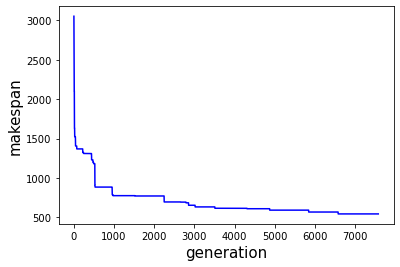

In [27]:
print(makespans)
# print(makespans_record)
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot([i for i in range(len(makespans_record))],makespans_record,'b')
plt.ylabel('makespan',fontsize=15)
plt.xlabel('generation',fontsize=15)
plt.show()